In [ ]:
from model import *
import argparse
from rl_env import *

In [63]:
env = AbiomedRLEnvFactory.create_env(
    model_name="10min_1hr_window",
    model_path=None,
    data_path=None,
    max_steps=24,
    action_space_type="discrete",
    reward_type="smooth",
    normalize_rewards=False,
    seed=42
)

/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model loaded from /abiomed/downsampled/models/10min_1hr_window_model.pth
loaded datasets with length 
 train:  4309 
 val:  709 
 test:  1266
Data loaded from /abiomed/downsampled/10min_1hr_window.pkl


In [64]:
ls models

a2c_20250717_0918.zip  ppo_20250717_0917.zip  ppo_20250717_0919.zip


In [65]:
from stable_baselines3 import PPO
model_device = "cuda:1"
policy = PPO("MlpPolicy", env, verbose=1, device=model_device)
policy = policy.load("models/ppo_20250717_0919")









Using cuda:1 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [79]:
from stable_baselines3.common.vec_env import DummyVecEnv

vec_env = DummyVecEnv([lambda: env])
obs = vec_env.reset()
traj_obs = [obs]
traj_actions = []
traj_rewards = []
for i in range(24):
    action, _states = policy.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    traj_obs.append(obs)
    traj_actions.append(action)
    traj_rewards.append(rewards)


traj_obs = np.array(traj_obs)
traj_obs = traj_obs.reshape(25, 6 , 12)
traj_actions = np.array(traj_actions)
traj_rewards = np.array(traj_rewards)
print(traj_obs.shape, traj_actions.shape, traj_rewards.shape)

(25, 6, 12) (24, 1) (24, 1)


In [80]:

# unnorm x
pred = torch.tensor(traj_obs)
std = env.world_model.std
mean = env.world_model.mean
columns = env.world_model.columns
x_unnorm = pred.cpu() * std[columns] + mean[columns]
print(x_unnorm.shape)

torch.Size([25, 6, 12])


In [72]:
def plot_output(env, pred, pl):
    
    # unnorm x
    pred = torch.tensor(pred)

    std = env.world_model.std
    mean = env.world_model.mean
    columns = env.world_model.columns
    x_unnorm = pred.cpu() * std[columns] + mean[columns]

    total_len =  pred.shape[1] * pred.shape[0]

    fig, ax1 = plt.subplots()

    ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x/6:.1f}"))

    color = "tab:red"
    ax1.set_xlabel("time (hr)")
    ax1.set_ylabel("MAP", color=color)
    # multiple samples
    x_unnorm = x_unnorm.reshape(-1, 12)
    ax1.plot(
                np.arange(0, total_len, 1),
                x_unnorm[:, 0],
                color=color,
                linewidth=0.5,
                alpha=0.5,
    )
    ax1.lines[-1].set_label("prediction")

    ax1.legend()
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = "tab:blue"
    ax2.set_ylabel(
        "P-Level", color=color
    )  # we already handled the x-label with ax1
    ax2.plot(np.arange(0, total_len, 1), x_unnorm[:, 11], color=color, linewidth=1, alpha=0.5)
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.set_ylim(0, 10)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



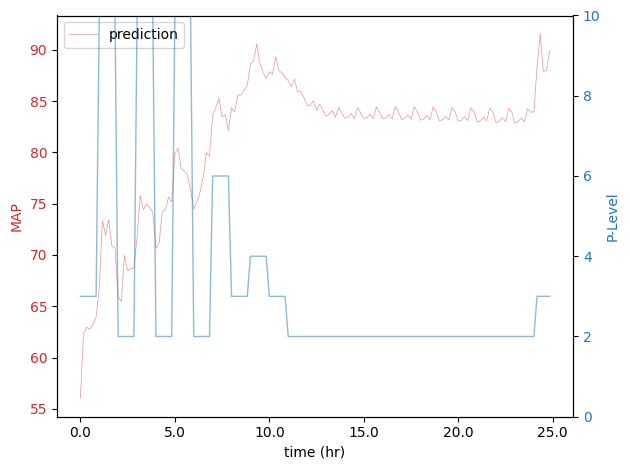

Total reward: [-55.801254]


In [81]:
plot_output(env, traj_obs, traj_actions)
rewards = sum(traj_rewards)
print(f"Total reward: {rewards}")